# 2D Wave Equation Simulation
This notebook simulates the propagation of a wave in two dimensions using the finite difference method.

## The 2D Wave Equation
The equation for a wave propagating in a 2D isotropic medium is given by:

$$ \frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) $$

where:
- \( u(x, y, t) \) is the displacement of the wave at position \( (x, y) \) and time \( t \).
- \( c \) is the speed of wave propagation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### Discretization using Finite Differences

To solve this equation numerically, we discretize it. The second-order partial derivatives can be approximated as:

$$ \frac{\partial^2 u}{\partial t^2} \approx \frac{u(x, y, t+\Delta t) - 2u(x, y, t) + u(x, y, t-\Delta t)}{(\Delta t)^2} $$

$$ \frac{\partial^2 u}{\partial x^2} \approx \frac{u(x+\Delta x, y, t) - 2u(x, y, t) + u(x-\Delta x, y, t)}{(\Delta x)^2} $$

$$ \frac{\partial^2 u}{\partial y^2} \approx \frac{u(x, y+\Delta y, t) - 2u(x, y, t) + u(x, y-\Delta y, t)}{(\Delta y)^2} $$

Substituting these into the wave equation and rearranging for \( u(x, y, t+\Delta t) \) (which we can write as \( u_{i,j}^{n+1} \)), we get the update rule:

$$ u_{i,j}^{n+1} = 2u_{i,j}^n - u_{i,j}^{n-1} + C^2 \left( u_{i+1,j}^n + u_{i-1,j}^n + u_{i,j+1}^n + u_{i,j-1}^n - 4u_{i,j}^n \right) $$

where
- $C = c \frac{\Delta t}{\Delta x}$ \) is the Courant number, assuming $\Delta x = \Delta y$.
- For stability, we must have $C \le \frac{1}{\sqrt{2}}$.

In [2]:
# Simulation parameters
grid_size = 100      # Grid size (grid_size x grid_size)
dx = 0.1             # Spatial step
c = 1.0              # Wave speed
dt = dx * 0.5 / c    # Time step (for stability, Courant number <= 1/sqrt(2))
end_time = 20        # Total simulation time

In [4]:
import numpy as np


def solve_wave_equation_2d(Lx=1.0, Ly=1.0, T=2.0, Nx=100, Ny=100, Nt=500, c=1.0,
                            initial_condition=None, boundary_type='dirichlet',
                            damping=0.0, dispersion=0.0):
    """
    Solve the 2D wave equation using the FDTD method.

    Parameters:
    -----------
    Lx, Ly : float
        Domain size in x and y directions
    T : float
        Total simulation time
    Nx, Ny : int
        Number of spatial points in x and y
    Nt : int
        Number of time steps
    c : float
        Wave speed
    initial_condition : function or None
        Function u(x, y) for initial displacement
    boundary_type : str
        'dirichlet', 'neumann', or 'periodic'
    damping : float
        Damping coefficient gamma
    dispersion : float
        Dispersion coefficient alpha

    Returns:
    --------
    u : ndarray
        Wave field with shape (Nt, Ny, Nx)
    x, y, t : ndarray
        Spatial and temporal grids
    """
    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)
    dt = T / Nt
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    t = np.linspace(0, T, Nt)

    # Courant condition (assuming dx = dy)
    r = c * dt / dx
    if r >= 1.0:
        raise ValueError(f"Unstable: Courant number r = {r:.3f} >= 1.0")

    # Initialize wavefields
    u = np.zeros((Nt, Ny, Nx))

    # Initial condition
    if initial_condition is None:
        X, Y = np.meshgrid(x, y)
        xc, yc = Lx / 2, Ly / 2
        width = 0.1
        u[0] = np.exp(-((X - xc)**2 + (Y - yc)**2) / (2 * width**2))
    else:
        u[0] = initial_condition(x, y)

    # Second time step
    u[1, 1:-1, 1:-1] = (u[0, 1:-1, 1:-1] +
                         0.5 * r**2 * (
                             u[0, 2:, 1:-1] + u[0, :-2, 1:-1] +
                             u[0, 1:-1, 2:] + u[0, 1:-1, :-2] -
                             4 * u[0, 1:-1, 1:-1]))

    u[1] = _apply_boundaries_2d(u[1], boundary_type)

    # Time evolution
    for n in range(1, Nt - 1):
        u_xx = u[n, 2:, 1:-1] + u[n, :-2, 1:-1] + u[n, 1:-1, 2:] + u[n, 1:-1, :-2] - 4 * u[n, 1:-1, 1:-1]
        u_t = (u[n, 1:-1, 1:-1] - u[n-1, 1:-1, 1:-1]) / dt

        u[n+1, 1:-1, 1:-1] = (2 * u[n, 1:-1, 1:-1] - u[n-1, 1:-1, 1:-1] +
                              r**2 * u_xx -
                              damping * dt * u_t)

        u[n+1] = _apply_boundaries_2d(u[n+1], boundary_type)

    return u, x, y, t


def _apply_boundaries_2d(u_slice, boundary_type):
    if boundary_type == 'dirichlet':
        u_slice[0, :] = 0
        u_slice[-1, :] = 0
        u_slice[:, 0] = 0
        u_slice[:, -1] = 0
    elif boundary_type == 'neumann':
        u_slice[0, 1:-1] = u_slice[1, 1:-1]
        u_slice[-1, 1:-1] = u_slice[-2, 1:-1]
        u_slice[1:-1, 0] = u_slice[1:-1, 1]
        u_slice[1:-1, -1] = u_slice[1:-1, -2]
    elif boundary_type == 'periodic':
        u_slice[0, :] = u_slice[-2, :]
        u_slice[-1, :] = u_slice[1, :]
        u_slice[:, 0] = u_slice[:, -2]
        u_slice[:, -1] = u_slice[:, 1]
    return u_slice


def gaussian_pulse_2d(x, y, center=(0.5, 0.5), width=0.1):
    X, Y = np.meshgrid(x, y)
    return np.exp(-((X - center[0])**2 + (Y - center[1])**2) / (2 * width**2))


In [80]:
def heatmap_2d(u, x, y, t, pulses=None, title=""):
    Nt, Ny, Nx = u.shape
    Lx, Ly = x[-1] - x[0], y[-1] - y[0]
    
    times_to_show = [0, Nt // 3, 2 * Nt // 3]

    # Create subplots with shared y-axis
    fig, axes = plt.subplots(1, len(times_to_show), figsize=(7, 2.5), 
                            sharey=True, constrained_layout=True)

    for i, time_idx in enumerate(times_to_show):
        ax = axes[i]
        im = ax.imshow(u[time_idx], extent=[x[0], x[-1], y[0], y[-1]], origin='lower',
                       cmap="RdBu_r", vmin=-0.5, vmax=0.5, aspect='auto')

        ax.set_title(f"t = {t[time_idx]:.2f}s", fontsize=12)
        ax.set_xlabel("")
        ax.set_ylabel("")
        
        ax.grid(False)

        if i == 0 and pulses:
            for j, (x_p, y_p, width, amp) in enumerate(pulses):
                pulse_type = "pos" if amp > 0 else "neg"
                label = f"{pulse_type} pulse"

                # Offset to avoid overlap
                offset_x = 0.1 * Lx if x_p < x[0] + 0.5 * Lx else -0.1 * Lx
                offset_y = 0.1 * Ly * ((j % 3) - 1)

                ax.annotate(label, xy=(x_p, y_p),
                            xytext=(x_p + offset_x, y_p + offset_y),
                            arrowprops=dict(arrowstyle='->', color='black', alpha=0.8),
                            fontsize=8, ha='center', color='black',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                                    edgecolor='black', alpha=0.9))

    # Add colorbar
    cbar = fig.colorbar(im, ax=axes, shrink=0.9)
    cbar.set_label("Displacement")

    fig.suptitle(title, fontsize=14)
    fig.supxlabel("x")
    fig.supylabel("y")

    if pulses:
        for i, pulse in enumerate(pulses):
            x_p, y_p, *_, amp = pulse
            print(f"  Pulse {i+1}: x = {x_p:.3f}, y = {y_p:.3f}, amplitude = {amp:.3f}")


  Pulse 1: x = 0.500, y = 0.500, amplitude = 1.000
  Pulse 2: x = 0.300, y = 0.700, amplitude = -0.500


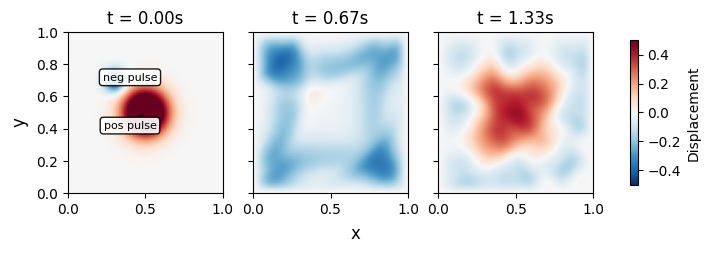

In [89]:
def combined_gaussian_pulses(x, y, pulses):
    """
    Sum multiple gaussian_pulse_2d with amplitudes.

    Parameters:
    - x, y: 1D spatial arrays
    - pulses: list of tuples (x0, y0, width, amplitude)

    Returns:
    - u0: 2D array initial displacement
    """
    u0 = np.zeros((len(y), len(x)))
    for (x0, y0, width, amp) in pulses:
        pulse = gaussian_pulse_2d(x, y, center=(x0, y0), width=width)
        u0 += amp * pulse
    return u0

pulses = [
    (0.5, 0.5, 0.1, 1.0),    # center at (0.5,0.5), width=0.1, amplitude=1.0
    (0.3, 0.7, 0.05, -0.5),  # another pulse
]

u, x, y, t = solve_wave_equation_2d(
    Lx=1.0, Ly=1.0, T=2.0, Nx=100, Ny=100, Nt=400,
    initial_condition=lambda x, y: combined_gaussian_pulses(x, y, pulses)
)

# Visualize - pass all the pulses for annotation
heatmap_2d(u, x, y, t, pulses=pulses)



In [95]:
def animate_wave_2d(u, x, y, t, pulses=None, 
                     interval=50, skip_frames=1, save_gif=False, filename="wave_2d.gif"):
    """
    Create an animation of the 2D wave equation solution.
    
    Parameters:
    -----------
    u : ndarray
        Wave field with shape (Nt, Ny, Nx)
    x, y, t : ndarray
        Spatial and temporal grids
    pulses : list of tuples, optional
        Initial pulse locations (x0, y0, width, amplitude)
    interval : int
        Time between frames in milliseconds
    skip_frames : int
        Number of frames to skip (for faster animation)
    save_gif : bool
        Whether to save animation as GIF
    filename : str
        Filename for saved GIF
        
    Returns:
    --------
    anim : FuncAnimation
        Animation object
    """
    Nt, Ny, Nx = u.shape
    Lx, Ly = x[-1] - x[0], y[-1] - y[0]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_aspect('equal')
    # Find global min/max for consistent colormap
    vmin, vmax = np.min(u), np.max(u)
    
    # Create initial image
    im = ax.imshow(u[0], extent=[x[0], x[-1], y[0], y[-1]], origin='lower',
                   cmap="RdBu_r", vmin=vmin, vmax=vmax, aspect='auto')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, shrink=0.9)
    cbar.set_label("Displacement", fontsize=12)
    
    # Set labels and title
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    
    # Add time text
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=12,
                       verticalalignment='top', bbox=dict(boxstyle='round', 
                       facecolor='white', alpha=0.8))
    # Annotate initial pulses (only on first frame)
    annotations = []
    if pulses:
        for j, (x_p, y_p, width, amp) in enumerate(pulses):
            pulse_type = "pos" if amp > 0 else "neg"
            label = f"{pulse_type} pulse"
            offset_x = 0.1 * Lx if x_p < x[0] + 0.5 * Lx else -0.1 * Lx
            offset_y = 0.1 * Ly * ((j % 3) - 1)
            ann = ax.annotate(label, xy=(x_p, y_p),
                              xytext=(x_p + offset_x, y_p + offset_y),
                              arrowprops=dict(arrowstyle='->', color='black', alpha=0.8),
                              fontsize=10, ha='center', color='black',
                              bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                                        edgecolor='black', alpha=0.9))
            annotations.append(ann)

    def animate(frame):
        time_idx = frame * skip_frames
        if time_idx >= Nt:
            time_idx = Nt - 1
        im.set_array(u[time_idx])
        time_text.set_text(f't = {t[time_idx]:.3f}s')
        # Only show annotations on the first frame
        if frame == 0:
            for ann in annotations:
                ann.set_visible(True)
        else:
            for ann in annotations:
                ann.set_visible(False)
        return [im, time_text] + annotations
    
    # Create animation
    frames = Nt // skip_frames
    anim = FuncAnimation(fig, animate, frames=frames, interval=interval, 
                        blit=True, repeat=True)
    plt.close(fig)
    
    # Save as GIF if requested
    if save_gif:
        print(f"Saving animation as {filename}...")
        anim.save(filename, writer='pillow', fps=1000//interval)
        print("Animation saved!")
    
    plt.tight_layout()
    return anim

## Animated Visualization

Now let's create an animation showing the wave propagation over time:

In [98]:
# Create and display the animation
anim = animate_wave_2d(u, x, y, t, pulses=pulses, 
                       interval=50, skip_frames=5)

# Display the animation in the notebook
HTML(anim.to_jshtml())

<Figure size 640x480 with 0 Axes>